In [41]:
import tensorflow.keras
tensorflow.keras.__version__

'2.1.6-tf'

# Understanding recurrent neural networks

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 6장 2절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

---

[...]

## 케라스의 순환 층


넘파이로 간단하게 구현한 과정이 실제 케라스의 `SimpleRNN` 층에 해당합니다:

In [42]:
from tensorflow.keras.layers import SimpleRNN

`SimpleRNN`이 한 가지 다른 점은 넘파이 예제처럼 하나의 시퀀스가 아니라 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리한다는 것입니다. 즉, `(timesteps, input_features)` 크기가 아니라 `(batch_size, timesteps, input_features)` 크기의 입력을 받습니다.

케라스에 있는 모든 순환 층과 동일하게 `SimpleRNN`은 두 가지 모드로 실행할 수 있습니다. 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나(크기가 `(batch_size, timesteps, output_features)`인 3D 텐서), 입력 시퀀스에 대한 마지막 출력만 반환할 수 있습니다(크기가 `(batch_size, output_features)`인 2D 텐서). 이 모드는 객체를 생성할 때 `return_sequences` 매개변수로 선택할 수 있습니다. 예제를 살펴보죠:

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [44]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있습니다. 이런 설정에서는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정해야 합니다:

In [45]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


이제 IMDB 영화 리뷰 분류 문제에 적용해 보죠. 먼저 데이터를 전처리합니다:

In [46]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')

"""
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

"""

###
# 혹시 안되면 아래 코드로 해보기

import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

###

print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

#print(input_train[0])
#print(len(input_train[0]))

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

#print(input_train[1])

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


`Embedding` 층과 `SimpleRNN` 층을 사용해 간단한 순환 네트워크를 훈련시켜 보겠습니다:

In [47]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 15s 754us/step - loss: 0.5678 - acc: 0.7037 - val_loss: 0.4377 - val_acc: 0.8088
Epoch 2/10
20000/20000 [==============================] - 15s 770us/step - loss: 0.3662 - acc: 0.8510 - val_loss: 0.3994 - val_acc: 0.8324
Epoch 3/10
20000/20000 [==============================] - 15s 763us/step - loss: 0.2810 - acc: 0.8901 - val_loss: 0.3591 - val_acc: 0.8562
Epoch 4/10
20000/20000 [==============================] - 16s 807us/step - loss: 0.2310 - acc: 0.9098 - val_loss: 0.3506 - val_acc: 0.8548
Epoch 5/10
20000/20000 [==============================] - 15s 762us/step - loss: 0.1815 - acc: 0.9336 - val_loss: 0.3565 - val_acc: 0.8652
Epoch 6/10
20000/20000 [==============================] - 15s 768us/step - loss: 0.1306 - acc: 0.9543 - val_loss: 0.4342 - val_acc: 0.8346
Epoch 7/10
20000/20000 [==============================] - 15s 766us/step - loss: 0.0918 - acc: 0.9688 - val_loss: 0.4

이제 훈련과 검증의 손실과 정확도를 그래프로 그립니다:

In [48]:
import matplotlib.pyplot as plt

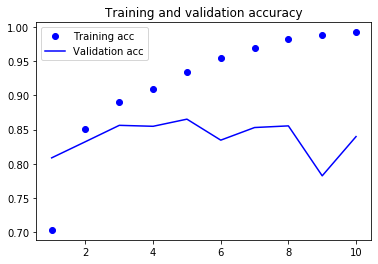

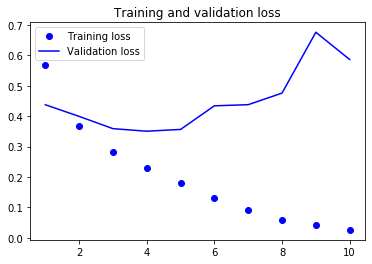

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

3장에서 이 데이터셋을 사용한 첫 번째 모델에서 얻은 테스트 정확도는 87%였습니다. 안타깝지만 간단한 순환 네트워크는 이 기준 모델보다 성능이 높지 않습니다(85% 정도의 검증 정확도를 얻었습니다). 이런 원인은 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문입니다. 이 RNN은 기준 모델보다 얻은 정보가 적습니다. 다른 이유는 `SimpleRNN`이 텍스트와 같이 긴 시퀀스를 처리하는데 적합하지 않기 때문입니다. 더 잘 작동하는 다른 순환 층이 있습니다. 조금 더 고급 순환 층을 살펴보죠.

In [50]:
results = model.evaluate(input_test, y_test)

25000/25000 [==============================] - 14s 565us/step


In [51]:
results

[0.5924870128583908, 0.83428]

In [52]:
model.predict(input_test)

array([[0.31761074],
       [0.9918938 ],
       [0.9593816 ],
       ...,
       [0.42795113],
       [0.00549877],
       [0.01867338]], dtype=float32)

[...]

## 케라스를 사용한 LSTM 예제

이제 실제적인 관심사로 이동해 보죠. LSTM 층으로 모델을 구성하고 IMDB 데이터에서 훈련해 보겠습니다(그림 6-16과 6-17 참조). 이 네트워크는 조금 전 `SimpleRNN`을 사용했던 모델과 비슷합니다. LSTM 층은 출력 차원만 지정하고 다른 (많은) 매개변수는 케라스의 기본값으로 남겨 두었습니다. 케라스는 좋은 기본값을 가지고 있어서 직접 매개변수를 튜닝하는 데 시간을 쓰지 않고도 거의 항상 어느정도 작동하는 모델을 얻을 수 있습니다.

In [34]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.5198 - acc: 0.7506 - val_loss: 0.3652 - val_acc: 0.8530
Epoch 2/10
20000/20000 [==============================] - 50s 3ms/step - loss: 0.3011 - acc: 0.8828 - val_loss: 0.3329 - val_acc: 0.8720
Epoch 3/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2390 - acc: 0.9104 - val_loss: 0.3128 - val_acc: 0.8628
Epoch 4/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.2009 - acc: 0.9266 - val_loss: 0.2862 - val_acc: 0.8780
Epoch 5/10
20000/20000 [==============================] - 50s 2ms/step - loss: 0.1793 - acc: 0.9391 - val_loss: 0.3054 - val_acc: 0.8832
Epoch 6/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.1577 - acc: 0.9447 - val_loss: 0.4403 - val_acc: 0.8196
Epoch 7/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.1447 - acc: 0.9489 - val_loss: 0.3274 - val_acc:

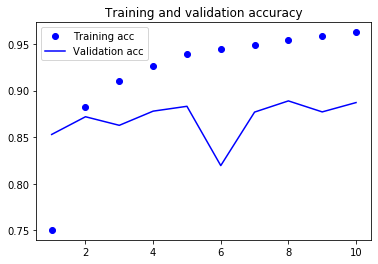

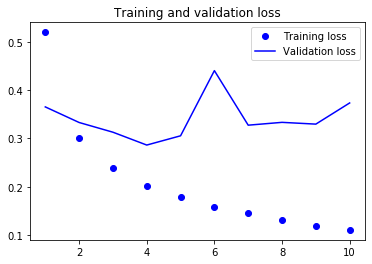

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
results = model.evaluate(input_test, y_test)

25000/25000 [==============================] - 34s 1ms/step


In [38]:
results

[0.449117960562706, 0.86132]

In [39]:
model.predict(input_test)

array([[0.03349079],
       [0.99689686],
       [0.88590723],
       ...,
       [0.00733738],
       [0.01326718],
       [0.07805593]], dtype=float32)